# Transfer Learning Tests for Kaggle Fingers Dataset

####  Context
- The goal of the project is to build a model able to count fingers as well as distinguish between left and right hand.

#### Content
- 21600 images of left and right hands fingers.
- All images are 128 by 128 pixels.

- Training set: 18000 images
- Test set: 3600 images
- Images are centered by the center of mass
- Noise pattern on the background

#### Labels
- Labels are in 2 last characters of a file name. L/R indicates left/right hand; 0,1,2,3,4,5 indicates number of fingers.

#### Note
- Images of a left hand were generated by flipping images of right hand.
- Later, the *training images* where divided in a *validation set* of 3600 images giving a training set of 14400 images

#### [Kaggle Fingers Dataset](https://www.kaggle.com/datasets/koryakinp/fingers)


### Importing Libraries

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import os
import numpy as np
from PIL import Image

import tarfile 
from io import BytesIO
import matplotlib.pyplot as plt

Determinate wich device will hold the dataset **cuda** or **cpu** based

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Data Loader

Because the images are in grayscale and we are using transfer learning in a VGG16 network. If we will freeze all layers and unfreeze the bottleneck we need to transform the simple grayscale finger image into a three (3) channel data.  VGG16 network was trained over color images.

In [3]:
def create_dataset_loaders(data, batch_size):
    training_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    valid_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    testing_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    train_data = ImageFolder(root=os.path.join(data, 'train'), transform=training_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    valid_data = ImageFolder(root=os.path.join(data, 'valid'), transform=valid_transform)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

    test_data = ImageFolder(root=os.path.join(data, 'test'), transform=testing_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 

    return train_loader, valid_loader, test_loader

In [4]:
# load dataloader
train_loader, valid_loader, test_loader = create_dataset_loaders('fingers_sorted', batch_size=32)

In [5]:
data = next(iter(train_loader))[0] # explore one tensor data

In [6]:
data.shape # we can see that we have data in format Tensor of shape (batch, channels, width, height)

torch.Size([32, 3, 128, 128])

#### Net Class

We will be using VGG16 as a pretrained network.  
- First we will load VGG16 imagenet weights of the model
- Preserve the weights and unfreeze the bottleneck
- Prepare a bottleneck classifier network
- make a simple class to utilice the network

NOTE:
- We can  unfreeze and change the convnet input feature to 1 channel, but we need to change the grayscale number of channels of the dataloader too to num_channels=1
- If we change the input channel is better to unfreeze all the others layers to train again the weights of this part of the network too

In [10]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
#        self.model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, padding=1)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 64),
            nn.Dropout(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

net = Net(num_classes=12) # load the net class to 12 classes (0 to 5 left fingers and 0 to 5 right fingers)

In [11]:
net = net.to(device) # decide which device will be used to train the network

In [12]:
net # visualize the network

Net(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

#### Training The Model

We will make use of this function to train the model.  Depending of the part of the model (train or validation) will output a path of training, report loss and other metrics

- SEE THE NOTE OF THE TRAINING IF YOU WANT TO TRAIN OVER ALL THE SAMPLES (I used only 20% of the dataset)

In [13]:
def train(model, train_loader, validation_loader, criterion, optimizer, device):
    epochs=2
    best_loss=1e6
    image_dataset={'train':train_loader, 'valid':validation_loader}
    loss_counter=0
    
    for epoch in range(epochs):
        for phase in ['train', 'valid']:
            print(f"Epoch {epoch}, Phase {phase}")
            if phase=='train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            running_samples=0

            for step, (inputs, labels) in enumerate(image_dataset[phase]):
                inputs=inputs.to(device)
                labels=labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase=='train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                running_samples+=len(inputs)
                if running_samples % 20  == 0:
                    accuracy = running_corrects/running_samples
                    print("Images [{}/{} ({:.0f}%)] Loss: {:.2f} Accuracy: {}/{} ({:.2f}%)".format(
                            running_samples,
                            len(image_dataset[phase].dataset),
                            100.0 * (running_samples / len(image_dataset[phase].dataset)),
                            loss.item(),
                            running_corrects,
                            running_samples,
                            100.0*accuracy,
                        )
                    )
                
                #NOTE: Comment lines below to train and test on whole dataset
                if running_samples>(0.2*len(image_dataset[phase].dataset)):
                    break

            epoch_loss = running_loss / running_samples
            epoch_acc = running_corrects / running_samples
            
            if phase=='valid':
                if epoch_loss<best_loss:
                    best_loss=epoch_loss
                else:
                    loss_counter+=1

        if loss_counter==1:
            break
    return model

#### Test The Model

We will make use of this function to test the model.  Same as before we will transport the data to the model and use it to make predicitoons on the whole testing set

In [14]:
def test(model, test_loader, criterion, device):
    print("Testing Model on Whole Testing Dataset")
    model.eval()
    running_loss=0
    running_corrects=0
    
    for inputs, labels in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects/ len(test_loader.dataset)
    print(f"Testing Accuracy: {100*total_acc}, Testing Loss: {total_loss}")

In [15]:
criterion = nn.CrossEntropyLoss() # load cross entropy loss because is a multiclass classification problem
optimizer = optim.SGD(net.parameters(), lr=1e-2) # load the adam optimizer with a default learning rate

In [16]:
trained_model = train(net, train_loader, valid_loader, criterion, optimizer, device) # started the training

Epoch 0, Phase train
Images [160/14400 (1%)] Loss: 2.20 Accuracy: 35/160 (21.88%)
Images [320/14400 (2%)] Loss: 1.96 Accuracy: 90/320 (28.12%)
Images [480/14400 (3%)] Loss: 1.84 Accuracy: 150/480 (31.25%)
Images [640/14400 (4%)] Loss: 1.75 Accuracy: 224/640 (35.00%)
Images [800/14400 (6%)] Loss: 1.46 Accuracy: 317/800 (39.62%)
Images [960/14400 (7%)] Loss: 1.17 Accuracy: 419/960 (43.65%)
Images [1120/14400 (8%)] Loss: 1.31 Accuracy: 522/1120 (46.61%)
Images [1280/14400 (9%)] Loss: 1.02 Accuracy: 625/1280 (48.83%)
Images [1440/14400 (10%)] Loss: 0.99 Accuracy: 725/1440 (50.35%)
Images [1600/14400 (11%)] Loss: 1.01 Accuracy: 846/1600 (52.88%)
Images [1760/14400 (12%)] Loss: 0.80 Accuracy: 962/1760 (54.66%)
Images [1920/14400 (13%)] Loss: 0.78 Accuracy: 1091/1920 (56.82%)
Images [2080/14400 (14%)] Loss: 0.67 Accuracy: 1216/2080 (58.46%)
Images [2240/14400 (16%)] Loss: 0.57 Accuracy: 1348/2240 (60.18%)
Images [2400/14400 (17%)] Loss: 0.74 Accuracy: 1481/2400 (61.71%)
Images [2560/14400 (18

In [17]:
test(model=trained_model, test_loader=test_loader, criterion=criterion, device=device) # test over the unseen data

Testing Model on Whole Testing Dataset
Testing Accuracy: 97.5, Testing Loss: 0.1698639745844735


### Model Save

We create this function to load the PyTorch model on the physical memory of this instance to later save in a *model.tar.gz* that is the required format which samemaker works (just for fun and to implement the function).

In [25]:
buffer = BytesIO()
state_dict_buffer = BytesIO()
torch.save(trained_model.state_dict(), state_dict_buffer)
with tarfile.open(fileobj=buffer, mode='w:gz') as tar:
    tarinfo = tarfile.TarInfo('model.pth')
    tarinfo.size = len(state_dict_buffer.getvalue())
    state_dict_buffer.seek(0)
    tar.addfile(tarinfo, state_dict_buffer)

with open(os.path.join("fingers_model","model.tar.gz"), "wb") as f:
    f.write(buffer.getvalue())

### Model Deployment Functions

As stated in the sagemaker pytorch documentation [here](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#deploy-pytorch-models) and [there](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/pytorch/get_started_mnist_deploy.html).  We have the option to control the flow of the inferences.

One thing to not is that ALWAYS if we want to deploy a model we will need a *model_fn* at least.

The steps are:
- model_fn
- input_fn
- predict_fn
- output_fn

In [26]:
def model_fn(model_dir):
    model = Net(num_classes=12)
    with open(os.path.join(model_dir, "model.pth"), 'rb') as f:
        model.load_state_dict(torch.load(f))
    model.to(device).eval()
    return model 

def input_fn(request_body, request_content_type):
    """An input_fn that loads a pickled tensor"""
    if request_content_type == 'application/png':
        return Image.open(BytesIO(request_body))
    else:
        # Handle other content-types here or raise an Exception
        print('can only process images')
        pass

def predict_fn(input_object, model):
    preprocess = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),        
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(input_object).unsqueeze(0)
    with torch.no_grad():
        prediction = model(input_tensor.to(device))
    return prediction

def output_fn(predictions, content_type):
    assert content_type=='application/json'
    classes = np.array(['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R'])
    predictions = predict_object.cpu().numpy()
    classes_sorted = classes[np.flip(predictions.argsort())]
    predictions.sort()
    predictions_proba = np.flip(predictions)
    json_res = dict(classes=classes_sorted, predictions=predictions_proba)
    return json_res

### Test over A Random Sample

Imagin we have an endpoint we will test the endpoint over the image, so we will mimick the situation with this steps.

In [44]:
# selectin a random test image
test_folder = os.path.join('fingers_sorted', 'test')
random_folder = np.random.choice(['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R'])
random_test_folder = os.path.join(test_folder, random_folder)
random_test_image = np.random.choice(os.listdir(random_test_folder))

# load the image (payload)
with open(os.path.join(random_test_folder, random_test_image), "rb") as f:
    image_data = f.read()

In [30]:
# when we run the estimator.predict(payload), the first thing is that the container willl load the model
model = model_fn('fingers_model')

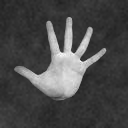

In [51]:
# later the input function is called with the payload
input_object = input_fn(request_body=image_data, request_content_type='application/png')
input_object

In [53]:
# after that the preprocessed input object is passed to the predict function
predict_object = predict_fn(input_object, model)
predict_object

tensor([[-0.9602, -4.4772,  1.7531,  0.1017, -2.8713, -3.0719, -0.4759, -3.6314,
          3.0383,  1.3356,  9.9793,  2.5121]], device='cuda:0')

In [54]:
# the output function will accomodate if you have it the implementation of the predictions
output_object = output_fn(predict_object, content_type='application/json')
output_object

{'classes': array([['5L', '4L', '5R', '1L', '4R', '1R', '3L', '0L', '2L', '2R', '3R',
         '0R']], dtype='<U2'),
 'predictions': array([[ 9.979345  ,  3.0382771 ,  2.5120857 ,  1.753074  ,  1.3356295 ,
          0.10168356, -0.47589839, -0.9601507 , -2.8713205 , -3.0719044 ,
         -3.6313815 , -4.477233  ]], dtype=float32)}

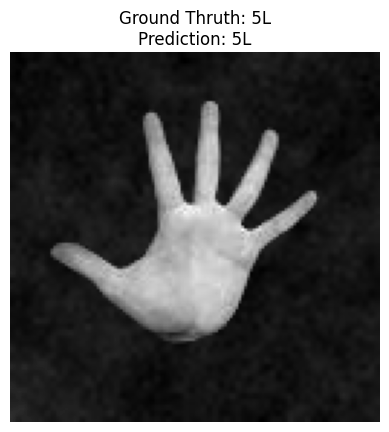

In [55]:
# plot to see if we have the same result of the labeled dataset
plt.imshow(Image.open(BytesIO(image_data)), cmap='gray');
gt = random_test_image.split('.')[0][-2:]
label = output_object['classes'][0][0]
plt.title(f'Ground Thruth: {gt}\nPrediction: {label}')
plt.axis(False)
plt.show()